In [2]:
import numpy as np
import pandas as pd
import anndata
import matplotlib.pyplot as plt
plt.rcParams["font.family"] = "DejaVu Sans"
import matplotlib.patches as mpatch
import matplotlib.colors as mcolors
import seaborn as sns
import colorsys

In [5]:
adata_exut = anndata.read_h5ad('../results/evaluations/exut_adata_evaluated_embeddings.h5ad')
adata_merfish = anndata.read_h5ad('../results/evaluations/merfish_adata_evaluated_embeddings.h5ad')
adata_smartseq = anndata.read_h5ad('../results/evaluations/smartseq_adata_evaluated_embeddings.h5ad')

adata_own = anndata.read_h5ad('../results/evaluations/O_RTK1_m_2a+b_adata_evaluated_embeddings.h5ad')
adata_own_a = anndata.read_h5ad('../results/evaluations/O_RTK1_m_2a_adata_evaluated_embeddings.h5ad')
adata_own_b = anndata.read_h5ad('../results/evaluations/O_RTK1_m_2b_adata_evaluated_embeddings.h5ad')

adata_mnist = anndata.read_h5ad('../results/evaluations/mnist_adata_evaluated_embeddings.h5ad')
adata_sim = anndata.read_h5ad('../results/evaluations/exut-sim-theta-10-real-seqdepths_adata_evaluated_embeddings.h5ad')

In [21]:
datasets = [adata_exut,adata_merfish,adata_smartseq,adata_own,adata_own_a,adata_own_b]

#### Use the same color mapping for the GB data set as used in the R pre-processing 

In [3]:
def assign_cell_type_colors(adatas, cell_type_col='clusternames'):
    """Assign specific colors to cell types across multiple AnnData objects based on a predefined mapping."""
    
    # Define the specific color mapping
    color_mapping = {
        "Astrocyte": "#1f77b4",
        "BDM": "#ff7f0e",
        "Endothelial": "#2ca02c",
        "GB.AC": "#d62728",
        "GB.G1.S": "#9467bd",
        "GB.G2.M": "#8c564b",
        "GB.MES2": "#e377c2",
        "GB.NPC1": "#7f7f7f",
        "MG": "#bcbd22",
        "Neurons_excit": "#17becf",
        "Neurons_inhib": "#aec7e8",
        "OPC": "#ff9896",
        "Oligodendrocyte": "#98df8a",
        "Pericyte": "#d62728",
        "Perivascular_fibroblast": "#c49c94",
        "SMC": "#f7b6d2",
        "T_cell": "#ffbb78"
    }

    # Assign colors to each AnnData object
    for adata in adatas:
        adata.obs[cell_type_col] = adata.obs[cell_type_col].astype(str).fillna("Unknown")  # Ensure string type
        adata.obs['colors'] = adata.obs[cell_type_col].map(color_mapping).fillna("#000000")  # Default to black if not found
    
    return color_mapping  # Return mapping for visualization

# Ensure consistent colors across all datasets
cell_type_to_color = assign_cell_type_colors([adata_own, adata_own_a, adata_own_b])

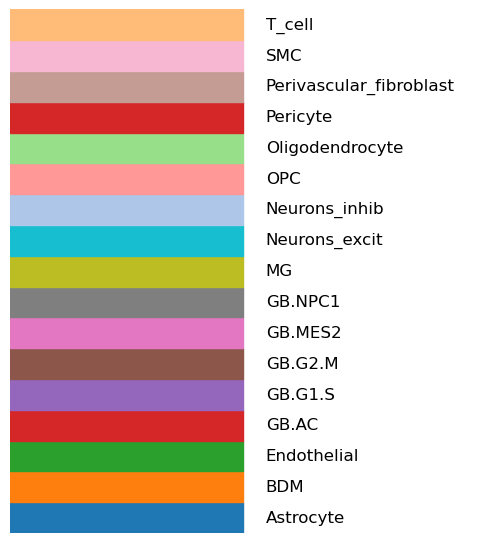

In [4]:
def plot_cell_type_colors(cell_type_to_color):
    fig, ax = plt.subplots(figsize=(6, len(cell_type_to_color) * 0.4))  

    for i, (cell_type, color) in enumerate(cell_type_to_color.items()):
        ax.add_patch(plt.Rectangle((0, i), 1, 1, color=color))  # Add color boxes
        ax.text(1.1, i + 0.5, f"{cell_type}", va="center", fontsize=12)

    ax.set_xlim(0, 2)
    ax.set_ylim(0, len(cell_type_to_color))
    ax.axis("off")
    plt.show()

plot_cell_type_colors(cell_type_to_color)

In [5]:
df = pd.DataFrame(list(cell_type_to_color.items()), columns=["Cell Type", "Color"])
df["Color"] = df["Color"].apply(mcolors.to_hex)  # Convert to HEX for readability
df.to_csv("../results/figures/main/cell_type_colors.csv", index=False)

print("Saved cell type colors to cell_type_colors.csv!")

Saved cell type colors to cell_type_colors.csv!


## Embeddings figure

In [37]:
pretty_titles = {'pca2':'2D PCA',
'elephant':'Picasso',
'tsne':'t-SNE',
'umap':'UMAP'}   

In [35]:
embedding_type2color ={'elephant':'tab:blue',
                        'pca2':'tab:orange',
                        'tsne':'tab:green',
                        'umap':'tab:red'}

In [55]:
pretty_datasets = {'O_RTK1_m_2a+b':'O_RTK1_m_2a+b',
                   'O_RTK1_m_2a':'O_RTK1_m_2a',
                   'O_RTK1_m_2b':'O_RTK1_m_2b',
                   'exut':'Ex Utero',
                   'merfish':'MERFISH',
                   'smartseq':'Smart-seq',
                   'mnist':'MNIST'}

In [4]:
## OLD ! ## 
embedding_type2color ={'elephant':'tab:blue',
                        'pca2':'tab:orange',
                        'tsne':'tab:green',
                        'umap':'tab:red'}
pretty_datasets = {'exut':'Ex Utero',
                   'merfish':'MERFISH',
                   'smartseq':'Smart-seq',
                   'mnist':'MNIST'}

In [33]:
def plot_embedding(ad,ax,embedding_type,seed_to_use,show_title=True):
    
    x = ad.obsm[f'x_{embedding_type}_seed_{seed_to_use}']
    colors = ad.obs['colors']
    
    #prepare random plotting order
    np.random.seed(seed=42)
    rnd_idx = np.random.permutation(len(colors))
    
    ax.scatter(*x[rnd_idx,:].T,c=colors[rnd_idx],s=3,lw=0,rasterized=True)
    ax.set_aspect('equal')
    ax.axis('off')
    if show_title:
        ax.set_title(pretty_titles[embedding_type])

def add_dataset_names(ax,ad,dataset_text_offset=0):
    ax.text(0.5,-0.05+dataset_text_offset,pretty_datasets[ad.uns['dataset']],transform=ax.transAxes,ha='center')

def plot_top_hlines(ax,fig,embedding_type,add_text=True,yline=0.9,ytext=0.895):
    
    xmin = {'pca2': 0.25,
            'elephant': 0,
            'tsne':0.5,
            'umap':0.75}
    
    ax.hlines(yline,xmin[embedding_type]+0.01,xmin[embedding_type]+0.25-0.01,color=embedding_type2color[embedding_type],lw=3,transform=fig.transFigure,clip_on=False,zorder=0)
    
    if add_text:
        ax.text(xmin[embedding_type]+0.125,ytext,s=pretty_titles[embedding_type],transform=fig.transFigure,ha='center',backgroundcolor='white',zorder=0)

In [39]:
n_cols=4
pagewidth=6.5
height=pagewidth/n_cols
embedding_types = ['elephant','pca2','tsne','umap']
seed_to_use=0

[6.5    2.4375]


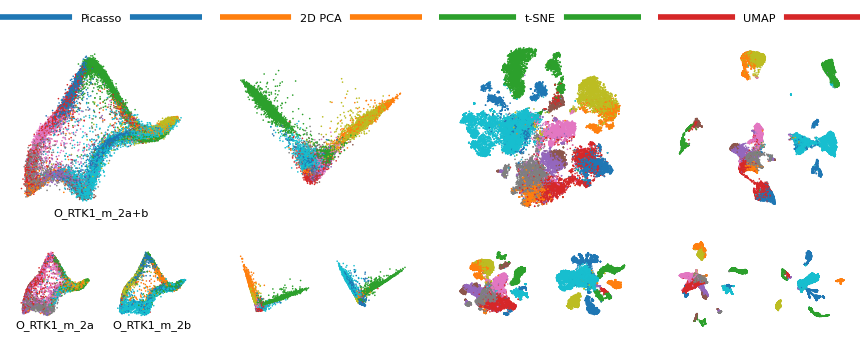

In [109]:
plt.rcParams["font.family"] = "DejaVu Sans"
import warnings
warnings.simplefilter("ignore")

with plt.style.context('../mpl_style.txt'):

    fig = plt.figure(figsize=(pagewidth,height*1.5))
    
    axes_large = [fig.add_axes(rect=[0.025+col*0.25,0.3,0.2,0.65],transform=fig.transFigure) for col in range(4)]
    axes_small_left = [fig.add_axes(rect=[0.03+col*(1/8),0,0.085,0.3],transform=fig.transFigure) for col in np.arange(8,step=2)]
    axes_small_right = [fig.add_axes(rect=[0.015+col*(1/8),0,0.085,0.3],transform=fig.transFigure) for col in np.arange(start=1,stop=8,step=2)]

    for ax,embedding_type in zip(axes_large,embedding_types):
        plot_embedding(ad=adata_own,ax=ax,embedding_type=embedding_type,seed_to_use=seed_to_use)
        ax.set_title('')
        plot_top_hlines(ax=ax,fig=fig,embedding_type=embedding_type,yline=0.96,ytext=0.948)
        if embedding_type=='elephant':
            add_dataset_names(ad=adata_own,ax=ax,dataset_text_offset=0)
        
    for ax,embedding_type in zip(axes_small_left,embedding_types):
        plot_embedding(ad=adata_own_a,ax=ax,embedding_type=embedding_type,seed_to_use=seed_to_use,show_title=False)
        if embedding_type=='elephant':
            add_dataset_names(ad=adata_own_a,ax=ax,dataset_text_offset=-0.08)

    for ax,embedding_type in zip(axes_small_right,embedding_types):
        plot_embedding(ad=adata_own_b,ax=ax,embedding_type=embedding_type,seed_to_use=seed_to_use,show_title=False)
        if embedding_type=='elephant':
            add_dataset_names(ad=adata_own_b,ax=ax,dataset_text_offset=-0.08)
            
    plt.tight_layout()
    fig.savefig(f'../results/figures/main/embeddings_combined_own.pdf', dpi=300, format=None, bbox_inches = 'tight', pad_inches = 0)
    fig.savefig(f'../results/figures/main/embeddings_combined_own.png', dpi=300, format=None, bbox_inches = 'tight', pad_inches = 0)    
    print(fig.get_size_inches())
    plt.show()

/tmp/ipykernel_16546/4148332623.py:26: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()
/tmp/ipykernel_16546/4148332623.py:26: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


[6.5    2.4375]


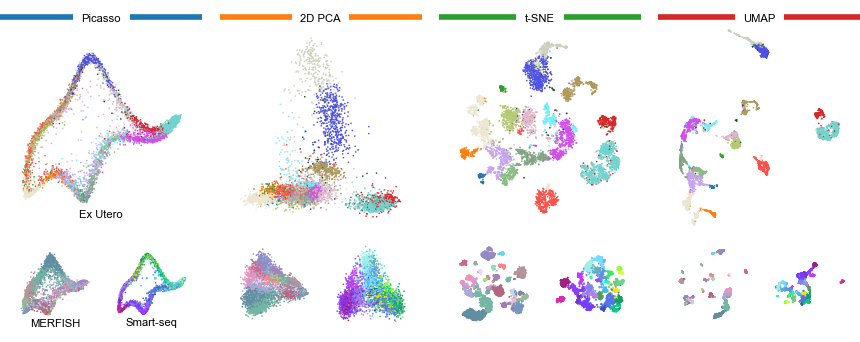

In [7]:
## OLD FIGURE ##
with plt.style.context('../mpl_style.txt'):

    fig = plt.figure(figsize=(pagewidth,height*1.5))
    
    axes_large = [fig.add_axes(rect=[0.025+col*0.25,0.3,0.2,0.65],transform=fig.transFigure) for col in range(4)]
    axes_small_left = [fig.add_axes(rect=[0.03+col*(1/8),0,0.085,0.3],transform=fig.transFigure) for col in np.arange(8,step=2)]
    axes_small_right = [fig.add_axes(rect=[0.015+col*(1/8),0,0.085,0.3],transform=fig.transFigure) for col in np.arange(start=1,stop=8,step=2)]

    for ax,embedding_type in zip(axes_large,embedding_types):
        plot_embedding(ad=adata_exut,ax=ax,embedding_type=embedding_type,seed_to_use=seed_to_use)
        ax.set_title('')
        plot_top_hlines(ax=ax,fig=fig,embedding_type=embedding_type,yline=0.96,ytext=0.948)
        if embedding_type=='elephant':
            add_dataset_names(ad=adata_exut,ax=ax,dataset_text_offset=0)
        
    for ax,embedding_type in zip(axes_small_left,embedding_types):
        plot_embedding(ad=adata_merfish,ax=ax,embedding_type=embedding_type,seed_to_use=seed_to_use,show_title=False)
        if embedding_type=='elephant':
            add_dataset_names(ad=adata_merfish,ax=ax,dataset_text_offset=-0.08)

    for ax,embedding_type in zip(axes_small_right,embedding_types):
        plot_embedding(ad=adata_smartseq,ax=ax,embedding_type=embedding_type,seed_to_use=seed_to_use,show_title=False)
        if embedding_type=='elephant':
            add_dataset_names(ad=adata_smartseq,ax=ax,dataset_text_offset=-0.08)
            
    plt.tight_layout()
    fig.savefig(f'../results/figures/main/embeddings_combined.pdf', dpi=300, format=None, bbox_inches = 'tight', pad_inches = 0)
    fig.savefig(f'../results/figures/main/embeddings_combined.png', dpi=300, format=None, bbox_inches = 'tight', pad_inches = 0)    
    print(fig.get_size_inches())
    plt.show()

## Metrics figure

In [6]:
datasets = [adata_own,adata_own_a,adata_own_b,adata_exut,adata_merfish,adata_smartseq]

In [7]:
#pool metric data frames for single cell datasets
metrics_df = pd.concat([ad.uns['metrics_df'] for ad in datasets])
ami_df =pd.concat([ad.uns['ami_df'] for ad in datasets])

In [16]:
ari_df =pd.concat([ad.uns['ari_df'] for ad in datasets])

In [17]:
#retrieve knn accuarcy and silhouette score for high dimensional space
knn_accuracies_hd = {ad.uns['dataset']:ad.uns['knn_accuracy_hd'] for ad in datasets}
silhouette_scores_hd = {ad.uns['dataset']:ad.uns['silhouette_hd'] for ad in datasets}

In [18]:
#get AMI for best HDBSCAN clustering run
def get_best_run(df,metric_name):
    '''input: df that only has one metric present'''
    df = df.copy()
    df.reset_index(inplace=True,drop=True)
    max_idx = df.groupby(by=['dataset','scaled','embedding_type','seed'],as_index=False)['metric_value'].idxmax()['metric_value']
    max_df = df.loc[max_idx,:]
    max_df['metric'] = f'max {metric_name}'
    
    return max_df

In [19]:
ami_max_df = get_best_run(ami_df,'AMI')

In [20]:
ari_max_df = get_best_run(ari_df,'ARI')

In [21]:
plot_df = pd.concat([metrics_df,ami_max_df,ari_max_df])
plot_df["embedding_x_dataset"] = plot_df["embedding_type"]+ "_x_" + plot_df['dataset']

In [22]:
#separate metrics from embeddings computed with and without Chari & Pachter scaling step
plot_df_normal = plot_df.query('scaled==False')
plot_df_scaled = plot_df.query('scaled==True')

### Plot prelims

In [152]:
palette = {'elephant_x_O_RTK1_m_2a+b':'tab:blue',
           'pca2_x_O_RTK1_m_2a+b':'tab:orange',
           'tsne_x_O_RTK1_m_2a+b':'tab:green',
           'umap_x_O_RTK1_m_2a+b':'tab:red',
           'dummy1':'k', #empty category for column spacing between datasets
           'dummy2':'k', #empty category for column spacing between datasets
           'elephant_x_O_RTK1_m_2a':'tab:blue',
           'pca2_x_O_RTK1_m_2a':'tab:orange',
           'tsne_x_O_RTK1_m_2a':'tab:green',
           'umap_x_O_RTK1_m_2a':'tab:red',
           'dummy3':'k', #empty category for column spacing between datasets
           'dummy4':'k', #empty category for column spacing between datasets
           'elephant_x_O_RTK1_m_2b':'tab:blue',
           'pca2_x_O_RTK1_m_2b':'tab:orange',
           'tsne_x_O_RTK1_m_2b':'tab:green',
           'umap_x_O_RTK1_m_2b':'tab:red'}

In [118]:
## OLD ## 
palette = {'elephant_x_exut':'tab:blue',
           'pca2_x_exut':'tab:orange',
           'tsne_x_exut':'tab:green',
           'umap_x_exut':'tab:red',
           'dummy1':'k', #empty category for column spacing between datasets
           'dummy2':'k', #empty category for column spacing between datasets
           'elephant_x_merfish':'tab:blue',
           'pca2_x_merfish':'tab:orange',
           'tsne_x_merfish':'tab:green',
           'umap_x_merfish':'tab:red',
           'dummy3':'k', #empty category for column spacing between datasets
           'dummy4':'k', #empty category for column spacing between datasets
           'elephant_x_smartseq':'tab:blue',
           'pca2_x_smartseq':'tab:orange',
           'tsne_x_smartseq':'tab:green',
           'umap_x_smartseq':'tab:red'}

In [88]:
col_order = [f'inter-centroid distance corr',
             f'intra-cluster distance corr',
             'kNN accuracy',
             'kNN recall',
             'silhouette_score',
             'max AMI']

pretty_metrics_dict = {f'inter-centroid distance corr':'Inter-class\ncorrelation',
                           f'intra-cluster distance corr':'Intra-class\ncorrelation',
                           'kNN accuracy':'kNN accuracy',
                           'kNN recall':"kNN recall",
                           'max AMI':'max. AMI across\nHDBSCAN parameters',
                           'max ARI':'max. AMI across\nHDBSCAN parameters',
                           'silhouette_score':'Silhouette coefficient'}

def plot_evals(plot_df,knn_accuracies_hd_dict,silhouette_scores_hd_dict,
               file_suffix,suptitle,folder='main',
               height=3,aspect=1.5,legend_loc=(0.6,0.3),scale=1):

    g = sns.FacetGrid(plot_df, col="metric",col_wrap=2,sharey=False,sharex=False,
                      height=height,aspect=aspect,
                      col_order=col_order)

    g.map_dataframe(sns.pointplot,
                    errorbar=("pi",100),
                    x='embedding_x_dataset',
                    hue='embedding_x_dataset',
                    markers=['o']*4 + ['^']*4 + ['s']*4,
                    errwidth=0.5,
                    y="metric_value",
                    palette=palette,
                    order=list(palette.keys()),
                    dodge=False,
                    scale=scale)
    
    legend_data = g._legend_data
    new_legend_data = {'2D PCA':legend_data['pca2_x_O_RTK1_m_2a+b'],
                       'Picasso':legend_data['elephant_x_O_RTK1_m_2a+b'],
                       't-SNE':legend_data['tsne_x_O_RTK1_m_2a+b'],
                       'UMAP':legend_data['umap_x_O_RTK1_m_2a+b']}    
    g.add_legend(legend_data=new_legend_data,loc=legend_loc,frameon=True,ncols=2,columnspacing=0.1,handletextpad=0.1)
    
    for (metric), ax in g.axes_dict.items():

        plt.sca(ax)
        
        tick_positions=[1.5,7.5,13.5]
        plt.xticks(tick_positions,['a+b','a','b'])
        
        plt.tick_params(bottom = False) 
        plt.xlabel('')
        
        plt.ylabel(pretty_metrics_dict[metric])
        plt.title('')  
        
        mindata_intra = np.min(plot_df.query(f'metric=="intra-cluster distance corr"')['metric_value'])
        
        ylim_lo = -0.05
        ax.set_yticks([0,0.5,1])

        
        if metric == f"inter-centroid distance corr":
            ylim_lo += mindata_intra            
            letter='a'            
            
        if metric == f"intra-cluster distance corr":
            ylim_lo += mindata_intra
            letter='b'
        
        if metric == "kNN accuracy":
            ax.hlines(knn_accuracies_hd_dict['O_RTK1_m_2a+b'],-0.5,3.5,colors='tab:gray',linestyles=':')
            ax.hlines(knn_accuracies_hd_dict['O_RTK1_m_2a'],5.5,9.5,colors='tab:gray',linestyles=':')
            ax.hlines(knn_accuracies_hd_dict['O_RTK1_m_2b'],11.5,15.5,colors='tab:gray',linestyles=':')
            ax.text(x=-0.1,y=knn_accuracies_hd_dict['O_RTK1_m_2a+b']+0.03,s='\nHD space',c='tab:gray',fontsize=5)
            letter='c'
            
        if metric == 'kNN recall':
            letter='d'
        
        if metric == 'max AMI':
            letter='f'
        
        if metric == 'max ARI':
            letter='g'
            
        if metric == 'silhouette_score':
            letter='e'
            ylim_lo += -0.5
            ax.set_yticks([-0.5,0,0.5,1])
            
            ax.hlines(silhouette_scores_hd_dict['O_RTK1_m_2a+b'],-0.5,3.5,colors='tab:gray',linestyles=':')
            ax.hlines(silhouette_scores_hd_dict['O_RTK1_m_2a'],5.5,9.5,colors='tab:gray',linestyles=':')
            ax.hlines(silhouette_scores_hd_dict['O_RTK1_m_2b'],11.5,15.5,colors='tab:gray',linestyles=':')
            ax.text(x=-0.1,y=silhouette_scores_hd_dict['O_RTK1_m_2a+b']+0.05,s='HD space',c='tab:gray',fontsize=5)
            
        ax.set_ylim(ylim_lo,top=1)
        for tick_pos in tick_positions:
            ax.hlines(ylim_lo,tick_pos-2,tick_pos+2,colors='k',lw=0.5)
    
    
        if letter in ['c','d']:
            y_correction=0.0025
        else:
            y_correction=0
        if letter in ['f']:
            x_correction=0.02
        else:
            x_correction=0
            
        ax.text(-0.19+x_correction,0.9675+y_correction,letter,transform=ax.transAxes,fontweight='bold',fontsize=8)
        plt.setp(ax.lines, zorder=100,clip_on=False)
        plt.setp(ax.collections, zorder=100, label="",clip_on=False)
        
    plt.tight_layout()
    sns.despine(trim=True,bottom=True)
    
    plt.suptitle(suptitle,y=1.03)
    g.figure.savefig(f'../results/figures/{folder}/metrics{file_suffix}_own.pdf', dpi=300, format=None, bbox_inches = 'tight', pad_inches = 0)
    g.figure.savefig(f'../results/figures/{folder}/metrics{file_suffix}_own.png', dpi=300, format=None, bbox_inches = 'tight', pad_inches = 0)
    
    plt.show()
    return g

In [ ]:
## OLD ## 
col_order = [f'inter-centroid distance corr',
             f'intra-cluster distance corr',
             'kNN accuracy',
             'kNN recall',
             'silhouette_score',
             'max AMI']

pretty_metrics_dict = {f'inter-centroid distance corr':'Inter-class\ncorrelation',
                           f'intra-cluster distance corr':'Intra-class\ncorrelation',
                           'kNN accuracy':'kNN accuracy',
                           'kNN recall':"kNN recall",
                           'max AMI':'max. AMI across\nHDBSCAN parameters',
                           'silhouette_score':'Silhouette coefficient'}

def plot_evals(plot_df,knn_accuracies_hd_dict,silhouette_scores_hd_dict,
               file_suffix,suptitle,folder='main',
               height=3,aspect=1.5,legend_loc=(0.6,0.3),scale=1):

    g = sns.FacetGrid(plot_df, col="metric",col_wrap=2,sharey=False,sharex=False,
                      height=height,aspect=aspect,
                      col_order=col_order)

    g.map_dataframe(sns.pointplot,
                    errorbar=("pi",100),
                    x='embedding_x_dataset',
                    hue='embedding_x_dataset',
                    markers=['o']*4 + ['^']*4 + ['s']*4,
                    errwidth=0.5,
                    y="metric_value",
                    palette=palette,
                    order=list(palette.keys()),
                    dodge=False,
                    scale=scale)
    
    legend_data = g._legend_data
    new_legend_data = {'2D PCA':legend_data['pca2_x_exut'],
                       'Picasso':legend_data['elephant_x_exut'],
                       't-SNE':legend_data['tsne_x_exut'],
                       'UMAP':legend_data['umap_x_exut']}    
    g.add_legend(legend_data=new_legend_data,loc=legend_loc,frameon=True,ncols=2,columnspacing=0.1,handletextpad=0.1)
    
    for (metric), ax in g.axes_dict.items():

        plt.sca(ax)
        
        tick_positions=[1.5,7.5,13.5]
        plt.xticks(tick_positions,['Ex Utero','MERFISH','Smart-seq'])
        
        plt.tick_params(bottom = False) 
        plt.xlabel('')
        
        plt.ylabel(pretty_metrics_dict[metric])
        plt.title('')  
        
        mindata_intra = np.min(plot_df.query(f'metric=="intra-cluster distance corr"')['metric_value'])
        
        ylim_lo = -0.05
        ax.set_yticks([0,0.5,1])

        
        if metric == f"inter-centroid distance corr":
            ylim_lo += mindata_intra            
            letter='a'            
            
        if metric == f"intra-cluster distance corr":
            ylim_lo += mindata_intra
            letter='b'
        
        if metric == "kNN accuracy":
            ax.hlines(knn_accuracies_hd_dict['exut'],-0.5,3.5,colors='tab:gray',linestyles=':')
            ax.hlines(knn_accuracies_hd_dict['merfish'],5.5,9.5,colors='tab:gray',linestyles=':')
            ax.hlines(knn_accuracies_hd_dict['smartseq'],11.5,15.5,colors='tab:gray',linestyles=':')
            ax.text(x=-0.1,y=knn_accuracies_hd_dict['exut']+0.03,s='\nHD space',c='tab:gray',fontsize=5)
            letter='c'
            
        if metric == 'kNN recall':
            letter='d'
        
        if metric == 'max AMI':
            letter='f'
            
        if metric == 'silhouette_score':
            letter='e'
            ylim_lo += -0.5
            ax.set_yticks([-0.5,0,0.5,1])
            
            ax.hlines(silhouette_scores_hd_dict['exut'],-0.5,3.5,colors='tab:gray',linestyles=':')
            ax.hlines(silhouette_scores_hd_dict['merfish'],5.5,9.5,colors='tab:gray',linestyles=':')
            ax.hlines(silhouette_scores_hd_dict['smartseq'],11.5,15.5,colors='tab:gray',linestyles=':')
            ax.text(x=-0.1,y=silhouette_scores_hd_dict['exut']+0.05,s='HD space',c='tab:gray',fontsize=5)
            
        ax.set_ylim(ylim_lo,top=1)
        for tick_pos in tick_positions:
            ax.hlines(ylim_lo,tick_pos-2,tick_pos+2,colors='k',lw=0.5)
    
    
        if letter in ['c','d']:
            y_correction=0.0025
        else:
            y_correction=0
        if letter in ['f']:
            x_correction=0.02
        else:
            x_correction=0
            
        ax.text(-0.17+x_correction,0.9675+y_correction,letter,transform=ax.transAxes,fontweight='bold',fontsize=8)
        plt.setp(ax.lines, zorder=100,clip_on=False)
        plt.setp(ax.collections, zorder=100, label="",clip_on=False)
        
    plt.tight_layout()
    sns.despine(trim=True,bottom=True)
    
    plt.suptitle(suptitle,y=1.03)
    g.figure.savefig(f'../results/figures/{folder}/metrics{file_suffix}.pdf', dpi=300, format=None, bbox_inches = 'tight', pad_inches = 0)
    g.figure.savefig(f'../results/figures/{folder}/metrics{file_suffix}.png', dpi=300, format=None, bbox_inches = 'tight', pad_inches = 0)
    
    plt.show()
    return g

In [ ]:
#select only L2-based metrics for remaining figures
l2_query = 'metric!="intra-cluster L1 distance corr" & metric!="inter-centroid L1 distance corr"'
plot_df_normal_l2 = plot_df_normal.query(l2_query)
plot_df_scaled_l2 = plot_df_scaled.query(l2_query)

### Main figure
(unscaled high-dimensional space used for embeddings and evaluation)

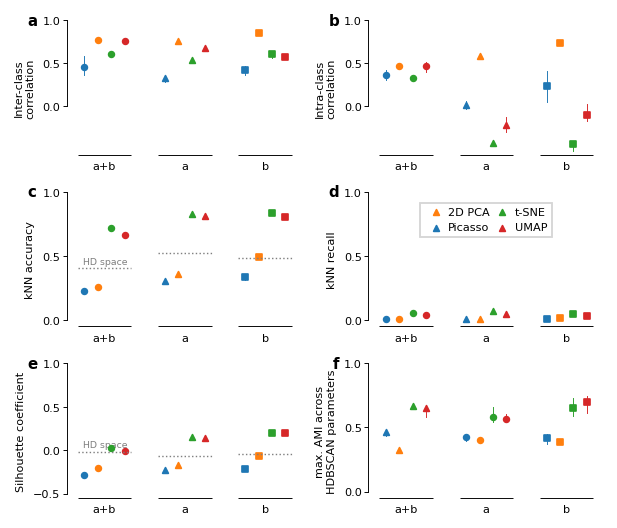

In [157]:
with plt.style.context('../mpl_style.txt'):
    g=plot_evals(plot_df_normal_l2,file_suffix="_unscaled_L2",suptitle="",
                 knn_accuracies_hd_dict=knn_accuracies_hd,silhouette_scores_hd_dict=silhouette_scores_hd,
                 height=1.3,aspect=1.377,legend_loc=(0.68,0.55),scale=0.9)

/home/jan/anaconda3/envs/elephant_analysis_env/lib/python3.11/site-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)
/home/jan/anaconda3/envs/elephant_analysis_env/lib/python3.11/site-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)
/tmp/ipykernel_16546/4028564553.py:110: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


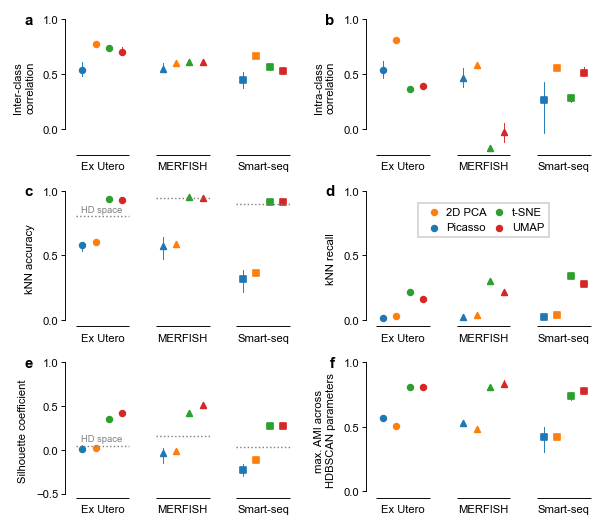

In [17]:
## OLD ##
with plt.style.context('../mpl_style.txt'):
    g=plot_evals(plot_df_normal_l2,file_suffix="_unscaled_L2",suptitle="",
                 knn_accuracies_hd_dict=knn_accuracies_hd,silhouette_scores_hd_dict=silhouette_scores_hd,
                 height=1.3,aspect=1.377,legend_loc=(0.68,0.55),scale=0.9)

### Numbers from the main figure reported in the manuscript

In [18]:
#minimum kNN accuracy across runs and datasets for UMAP or tSNE
min(plot_df.query('scaled==False & metric=="kNN accuracy"& (embedding_type=="tsne" | embedding_type=="umap")')['metric_value'])

0.9101298701298701

In [19]:
#means per dataset x embedding type
only_acc_df = plot_df.query('scaled==False & metric=="kNN accuracy"')
only_rec_df = plot_df.query('scaled==False & metric=="kNN recall"')
only_sil_df = plot_df.query('scaled==False & metric=="silhouette_score"')
only_ami_df = plot_df.query('scaled==False & metric=="max AMI"')
acc_means = only_acc_df.groupby(by=['dataset','embedding_type'])['metric_value'].aggregate(np.mean)
rec_means = only_rec_df.groupby(by=['dataset','embedding_type'])['metric_value'].aggregate(np.mean)
sil_means = only_sil_df.groupby(by=['dataset','embedding_type'])['metric_value'].aggregate(np.mean)
ami_means = only_ami_df.groupby(by=['dataset','embedding_type'])['metric_value'].aggregate(np.mean)
print('\n\nmean kNN accuracy\n')
print(acc_means.round(decimals=2))
print('\n\nmean kNN recall\n')
print(rec_means.round(decimals=2))
print('\n\nmean silhouette\n')
print(sil_means.round(decimals=2))
print('\n\nmean max AMI\n')
print(ami_means.round(decimals=2))



mean kNN accuracy

dataset   embedding_type
exut      elephant          0.58
          pca2              0.61
          tsne              0.93
          umap              0.93
merfish   elephant          0.57
          pca2              0.59
          tsne              0.95
          umap              0.95
smartseq  elephant          0.32
          pca2              0.37
          tsne              0.91
          umap              0.91
Name: metric_value, dtype: float64


mean kNN recall

dataset   embedding_type
exut      elephant          0.02
          pca2              0.03
          tsne              0.22
          umap              0.16
merfish   elephant          0.02
          pca2              0.04
          tsne              0.30
          umap              0.22
smartseq  elephant          0.02
          pca2              0.04
          tsne              0.34
          umap              0.28
Name: metric_value, dtype: float64


mean silhouette

dataset   embedding_type
exut

### Additional figure: Simple vs. class-size balanced accuracy

In [20]:
bal_knn_accuracies_hd = {ad.uns['dataset']:ad.uns['balanced_knn_accuracy_hd'] for ad in datasets}

In [21]:
def plot_simple_vs_balanced_acc(plot_df,
                                knn_accuracies_hd_dict,
                                bal_knn_accuracies_hd_dict,
                                file_suffix,
                                folder='supplementary',
                                height=3,aspect=1.5,legend_loc=(0.6,0.3),scale=1):
    
    col_order = ['balanced kNN accuracy',
             'kNN accuracy']
    pretty_metrics_dict = {    'balanced kNN accuracy':'balanced kNN accuracy',
                               'kNN accuracy':'kNN accuracy',}
    
    
    g = sns.FacetGrid(plot_df, col="metric",col_wrap=2,sharey=False,sharex=False,
                      height=height,aspect=aspect,
                      col_order=col_order)

    g.map_dataframe(sns.pointplot,
                    errorbar=("pi",100),
                    x='embedding_x_dataset',
                    hue='embedding_x_dataset',
                    markers=['o']*4 + ['^']*4 + ['s']*4,
                    errwidth=0.5,
                    y="metric_value",
                    palette=palette,
                    order=list(palette.keys()),
                    dodge=False,
                    scale=scale)
    
    legend_data = g._legend_data
    new_legend_data = {'2D PCA':legend_data['pca2_x_exut'],
                       'Picasso':legend_data['elephant_x_exut'],
                       't-SNE':legend_data['tsne_x_exut'],
                       'UMAP':legend_data['umap_x_exut']}    
    g.add_legend(legend_data=new_legend_data,loc=legend_loc,frameon=True,ncols=2,columnspacing=0.1,handletextpad=0.1)
    
    
    for (metric), ax in g.axes_dict.items():
        plt.sca(ax)
        
        tick_positions=[1.5,7.5,13.5]
        plt.xticks(tick_positions,['Ex Utero','MERFISH','Smart-seq'])
        
        plt.tick_params(bottom = False) 
        plt.xlabel('')
        
        plt.ylabel(pretty_metrics_dict[metric])
        plt.title('')  
        
        ylim_lo = -0.05
        ax.set_yticks([0,0.5,1])

        
        if metric == "kNN accuracy":
            ax.hlines(knn_accuracies_hd_dict['exut'],-0.5,3.5,colors='tab:gray',linestyles=':')
            ax.hlines(knn_accuracies_hd_dict['merfish'],5.5,9.5,colors='tab:gray',linestyles=':')
            ax.hlines(knn_accuracies_hd_dict['smartseq'],11.5,15.5,colors='tab:gray',linestyles=':')
            ax.text(x=-0.1,y=knn_accuracies_hd_dict['exut']+0.03,s='\nHD space',c='tab:gray',fontsize=5)
            letter='a'
            
        if metric == "balanced kNN accuracy":
            ax.hlines(bal_knn_accuracies_hd_dict['exut'],-0.5,3.5,colors='tab:gray',linestyles=':')
            ax.hlines(bal_knn_accuracies_hd_dict['merfish'],5.5,9.5,colors='tab:gray',linestyles=':')
            ax.hlines(bal_knn_accuracies_hd_dict['smartseq'],11.5,15.5,colors='tab:gray',linestyles=':')
            ax.text(x=-0.1,y=bal_knn_accuracies_hd_dict['exut']+0.03,s='\nHD space',c='tab:gray',fontsize=5)
            letter='b'

 
        ax.set_ylim(ylim_lo,top=1)
        for tick_pos in tick_positions:
            ax.hlines(ylim_lo,tick_pos-2,tick_pos+2,colors='k',lw=0.5)

            
        plt.setp(ax.lines, zorder=100,clip_on=False)
        plt.setp(ax.collections, zorder=100, label="",clip_on=False)
        
    plt.tight_layout()
    sns.despine(trim=True,bottom=True)
    
    g.figure.savefig(f'../results/figures/{folder}/metrics{file_suffix}.pdf', dpi=300, format=None, bbox_inches = 'tight', pad_inches = 0)
    g.figure.savefig(f'../results/figures/{folder}/metrics{file_suffix}.png', dpi=300, format=None, bbox_inches = 'tight', pad_inches = 0)
    
    return g

/home/jan/anaconda3/envs/elephant_analysis_env/lib/python3.11/site-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)
/home/jan/anaconda3/envs/elephant_analysis_env/lib/python3.11/site-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)
/tmp/ipykernel_16546/664267298.py:77: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


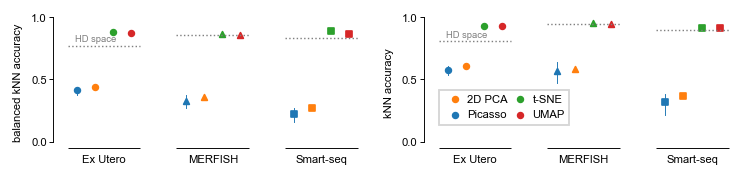

In [22]:
with plt.style.context('../mpl_style.txt'):
    g=plot_simple_vs_balanced_acc(plot_df_normal,file_suffix="_balanced_accuracy",
                 knn_accuracies_hd_dict=knn_accuracies_hd,bal_knn_accuracies_hd_dict=bal_knn_accuracies_hd,
                 height=1.3,aspect=1.777,legend_loc=(0.58,0.3),scale=0.9,)
    plt.show()

### Additional figure: L1 vs L2 distances in the Chari & Pachter distance correlation metrics: 

In [23]:
#make l1 vs l2 dataframe
l1l2_query = 'metric=="intra-cluster distance corr" | metric=="inter-centroid distance corr" | metric=="intra-cluster L1 distance corr" | metric=="inter-centroid L1 distance corr"'
plot_df_normal_l1l2 = plot_df_normal.query(l1l2_query)

In [24]:
def plot_l1_vs_l2(plot_df,height=3,aspect=1.5,legend_loc=(0.6,0.3),scale=1,l1_pachter=False):

    g = sns.FacetGrid(plot_df, col="metric",col_wrap=2,sharey=False,sharex=False,
                      height=height,aspect=aspect,
                      col_order=['inter-centroid L1 distance corr',
                                 'intra-cluster L1 distance corr',
                                 'inter-centroid distance corr',
                                 'intra-cluster distance corr'])

    pretty_metrics_dict = {'inter-centroid L1 distance corr':'L1 Inter-class\ncorrelation',
                       'inter-centroid distance corr':'L2 Inter-class\ncorrelation',
                       'intra-cluster L1 distance corr':'L1 Intra-class\ncorrelation',
                       'intra-cluster distance corr':'L2 Intra-class\ncorrelation'}
    
    g.map_dataframe(sns.pointplot,
                    errorbar=("pi",100),
                    x='embedding_x_dataset',
                    hue='embedding_x_dataset',
                    markers=['o']*4 + ['^']*4 + ['s']*4,
                    errwidth=0.5,
                    y="metric_value",
                    palette=palette,
                    order=list(palette.keys()),
                    dodge=False,
                    scale=scale)
    
    legend_data = g._legend_data
    new_legend_data = {'2D PCA':legend_data['pca2_x_exut'],
                    'Picasso':legend_data['elephant_x_exut'],
                    't-SNE':legend_data['tsne_x_exut'],
                    'UMAP':legend_data['umap_x_exut']}    
    g.add_legend(legend_data=new_legend_data,loc=legend_loc,frameon=True,ncols=2,columnspacing=0.1,handletextpad=0.1)
    
    for (metric), ax in g.axes_dict.items():

        plt.sca(ax)
        
        tick_positions=[1.5,7.5,13.5]
        plt.xticks(tick_positions,['Ex Utero','MERFISH','Smart-seq'])
        
        plt.tick_params(bottom = False) 
        plt.xlabel('')
        
        plt.ylabel(pretty_metrics_dict[metric])
        plt.title('')
        
        ylim_lo = min(plot_df['metric_value'])
        for tick_pos in tick_positions:
            ax.hlines(ylim_lo,tick_pos-2,tick_pos+2,colors='k',lw=0.5)
        
        ax.set_yticks([0,0.5,1])
        plt.setp(ax.lines, zorder=100,clip_on=False)
        plt.setp(ax.collections, zorder=100, label="",clip_on=False)
        
    plt.tight_layout()
    sns.despine(trim=True,bottom=True)
    
    g.figure.savefig('../results/figures/supplementary/chari_pachter_metrics_l1_vs_l2.pdf', dpi=300, format=None, bbox_inches = 'tight', pad_inches = 0)
    g.figure.savefig('../results/figures/supplementary/chari_pachter_metrics_l1_vs_l2.png', dpi=300, format=None, bbox_inches = 'tight', pad_inches = 0)

    plt.show()
    return g

/home/jan/anaconda3/envs/elephant_analysis_env/lib/python3.11/site-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)
/home/jan/anaconda3/envs/elephant_analysis_env/lib/python3.11/site-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)
/tmp/ipykernel_16546/850925672.py:55: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


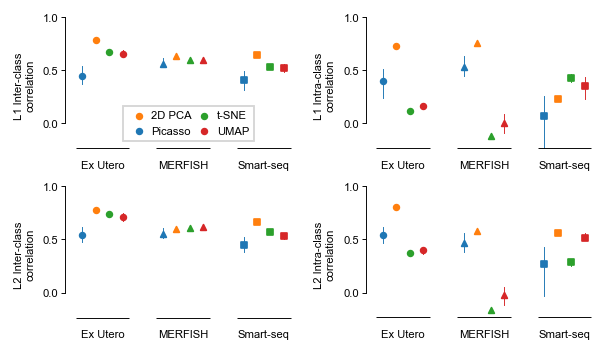

In [25]:
with plt.style.context('../mpl_style.txt'):
    plot_l1_vs_l2(plot_df_normal_l1l2,
                  legend_loc=(0.2,0.6),
                  height=1.3,aspect=1.377,scale=0.9)

### Additional figure: Chari & Pachter standardization step
(standardized high-dimensional space used as basis for embeddings, unscaled space used for evaluation)

/home/jan/anaconda3/envs/elephant_analysis_env/lib/python3.11/site-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)
/home/jan/anaconda3/envs/elephant_analysis_env/lib/python3.11/site-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)
/tmp/ipykernel_16546/4028564553.py:110: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


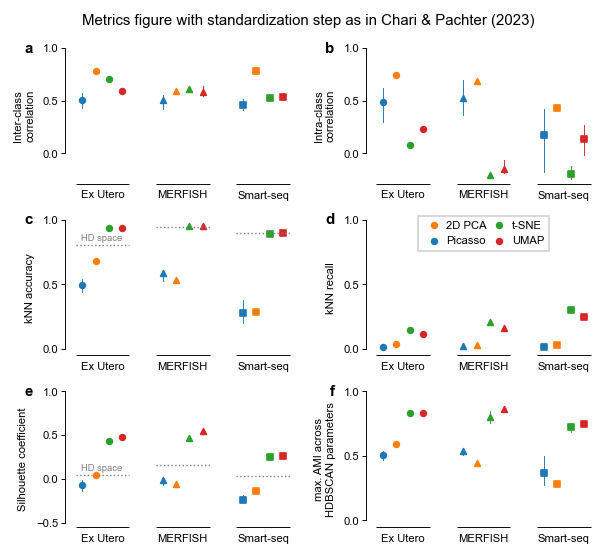

In [26]:
with plt.style.context('../mpl_style.txt'):
    g=plot_evals(plot_df_scaled_l2,file_suffix="_scaled_L2",suptitle="Metrics figure with standardization step as in Chari & Pachter (2023)",
                 folder='supplementary',
                 knn_accuracies_hd_dict=knn_accuracies_hd,silhouette_scores_hd_dict=silhouette_scores_hd,
                 height=1.3,aspect=1.377,legend_loc=(0.68,0.55),scale=0.9)

## Additional datasets

In [130]:
## two rows... ##
def plot_evals_single_dataset(ad, plot_df, legend_loc_metrics=(0.05, 0.3), legend_panel_metrics='kNN recall', pca50_df=None):
    import matplotlib.pyplot as plt
    import seaborn as sns
    import numpy as np

    ## PREPARE
    fig = plt.figure(figsize=(8, 7/4*2))  # Keeping the figure width to maintain spacing
    axes_embeddings = [fig.add_axes(rect=[0.025 + col * 0.25, 0.55, 0.2, 0.4], transform=fig.transFigure) for col in range(4)]
    
    # Adjusted x-coordinates back to original position while maintaining increased vertical spacing
    axes_metrics = [fig.add_axes(rect=[0.07 + (col % 5) * (1/5.2), 0.28 if col < 5 else 0.02, 0.14, 0.22], transform=fig.transFigure) for col in range(10)]
    
    ## EMBEDDINGS
    embedding_types = ['elephant', 'pca2', 'tsne', 'umap']
    for ax, embedding_type in zip(axes_embeddings, embedding_types):
        plot_top_hlines(ax=ax, fig=fig, embedding_type=embedding_type, yline=0.96, ytext=0.95)
        plot_embedding(ad=ad, ax=ax, embedding_type=embedding_type, seed_to_use=seed_to_use)
        ax.set_title('')

    ## METRICS
    metrics = np.unique(plot_df['metric'])
    metrics_ordered = metrics[:10]  # Ensuring we only select 10 metrics
    for metric, ax in zip(metrics_ordered, axes_metrics):
        metric_idx = plot_df['metric'] == metric
        data = plot_df.loc[metric_idx, :].copy()

        palette = {'Picasso': 'tab:blue',
                   '2D PCA': 'tab:orange',
                   't-SNE': 'tab:green',
                   'UMAP': 'tab:red'}
        embedding_type_pretty_dict = {'pca2': '2D PCA',
                                      'elephant': 'Picasso',
                                      'tsne': 't-SNE',
                                      'umap': 'UMAP'}

        data['embedding_type_pretty'] = [embedding_type_pretty_dict[et] for et in data['embedding_type'].values]

        sns.pointplot(data=data, x='embedding_type_pretty', y='metric_value', hue='embedding_type_pretty',
                      ax=ax, errorbar=("pi", 100), errwidth=0.5,
                      palette=palette, order=list(palette.keys()))

        if metric == "kNN accuracy":
            ax.hlines(ad.uns['knn_accuracy_hd'], -0.5, 3.5, colors='tab:gray', linestyles=':')
            ax.text(x=1.3, y=ad.uns['knn_accuracy_hd'] + 0.03, s='\nHD space', c='tab:gray', fontsize=5)
        
        if metric == 'silhouette_score':
            ax.hlines(ad.uns['silhouette_hd'], -0.5, 3.5, colors='tab:gray', linestyles=':')
            ax.text(x=1.3, y=ad.uns['silhouette_hd'] + 0.05, s='HD space', c='tab:gray', fontsize=5)
    
        if metric in ['kNN accuracy', 'silhouette_score'] and pca50_df is not None:
            ax.hlines(pca50_mean_df.loc[metric, 'metric_value'], -0.5, 3.5, colors='tab:gray', linestyles=':')
            ax.text(x=-0.45, y=pca50_mean_df.loc[metric, 'metric_value'] + 0.03, s='\nPCA 50D', c='tab:gray', fontsize=5)
    
        if metric == 'kNN recall':
            ax.legend(frameon=True, loc=legend_loc_metrics, columnspacing=0.1, handletextpad=0.1)  
        else:
            ax.get_legend().remove()
    
        ax.set_ylim(-1, 1) if metric in ['inter-centroid distance corr', 'intra-cluster distance corr', 'silhouette_score'] else ax.set_ylim(0, 1)
        ax.set_xticks([])
        ax.set_ylabel(pretty_metrics_dict.get(metric, metric))
        ax.set_xlabel('')
    
    fig.savefig(f'../results/figures/supplementary/results_{ad.uns["dataset"]}.pdf', dpi=300, bbox_inches='tight', pad_inches=0)
    fig.savefig(f'../results/figures/supplementary/results_{ad.uns["dataset"]}.png', dpi=300, bbox_inches='tight', pad_inches=0)    
    plt.show()


In [6]:
# One row #
def plot_evals_single_dataset(ad,plot_df,legend_loc_metrics = (0.05,0.3),legend_panel_metrics='kNN recall',pca50_df=None):

    ## PREPARE
    fig = plt.figure(figsize=(6.5,6.5/4*1.5))
    axes_embeddings = [fig.add_axes(rect=[0.025+col*0.25,0.32,0.2,0.65],transform=fig.transFigure) for col in range(4)]
    axes_metrics = [fig.add_axes(rect=[0.06+col*(1/7),0,0.085,0.3],transform=fig.transFigure) for col in range(7)]

    ## EMBEDDINGS
    embedding_types = ['elephant','pca2','tsne','umap']
    for ax,embedding_type,xpos in zip(axes_embeddings,embedding_types,[0.13,0.37,0.63,0.87]):
        plot_top_hlines(ax=ax,fig=fig,embedding_type=embedding_type,yline=0.96,ytext=0.95)
        plot_embedding(ad=ad,ax=ax,embedding_type=embedding_type,seed_to_use=seed_to_use)
        ax.set_title('')

    ## METRICS
    metrics = np.unique(plot_df['metric'])
    metrics_ordered = metrics[[0,1,2,3,4,5,6]] # metrics[[0,1,2,3,5,4]]
    for metric, ax  in zip(metrics_ordered,axes_metrics):

        metric_idx = plot_df['metric']==metric
        data = plot_df.loc[metric_idx,:].copy()

        palette = {'Picasso':'tab:blue',
               '2D PCA':'tab:orange',
               't-SNE':'tab:green',
               'UMAP':'tab:red'}
        embedding_type_pretty_dict = {'pca2':'2D PCA',
                       'elephant':'Picasso',
                       'tsne':'t-SNE',
                       'umap':'UMAP'}

        embedding_types = data['embedding_type'].values
        data['embedding_type_pretty'] = [embedding_type_pretty_dict[et] for et in embedding_types]

        sns.pointplot(data=data,x='embedding_type_pretty',y='metric_value',hue='embedding_type_pretty',
                      ax=ax,
                      errorbar=("pi",100), errwidth=0.5,
                      palette=palette, order=list(palette.keys()))
        
        
        
        if metric == "kNN accuracy":
            ax.hlines(ad.uns['knn_accuracy_hd'],-0.5,3.5,colors='tab:gray',linestyles=':')
            ax.text(x=1.3,y=ad.uns['knn_accuracy_hd']+0.03,s='\nHD space',c='tab:gray',fontsize=5)
        
        if metric == 'silhouette_score':
            ax.hlines(ad.uns['silhouette_hd'],-0.5,3.5,colors='tab:gray',linestyles=':')
            ax.text(x=1.3,y=ad.uns['silhouette_hd']+0.05,s='HD space',c='tab:gray',fontsize=5)
    
        if metric in ['kNN accuracy','silhouette_score'] and pca50_df is not None:
            #optional PCA50 line
            ax.hlines(pca50_mean_df.loc[metric,'metric_value'],-0.5,3.5,colors='tab:gray',linestyles=':')
            ax.text(x=-0.45,y=pca50_mean_df.loc[metric,'metric_value']+0.03,s='\nPCA 50D',c='tab:gray',fontsize=5)

        if metric == 'kNN recall':
            ax.legend(frameon=True,loc=legend_loc_metrics,columnspacing=0.1,handletextpad=0.1)  
        else:
            ax.get_legend().remove()

        if metric in ['inter-centroid distance corr', 'intra-cluster distance corr', 'silhouette_score']:
            ax.set_ylim(-1,1)
            ax.set_yticks([-1,0,1])
        else:
            ax.set_ylim(0,1)
            ax.set_yticks([0,0.5,1])
        
        
        ax.set_xticks([])
        ax.set_ylabel(pretty_metrics_dict[metric])
        ax.set_xlabel('')

        plt.setp(ax.lines, zorder=100,clip_on=False)
        plt.setp(ax.collections, zorder=100, label="",clip_on=False)

    fig.savefig(f'../results/figures/supplementary/results_{ad.uns["dataset"]}.pdf', dpi=300, format=None, bbox_inches = 'tight', pad_inches = 0)
    fig.savefig(f'../results/figures/supplementary/results_{ad.uns["dataset"]}.png', dpi=300, format=None, bbox_inches = 'tight', pad_inches = 0)    
    plt.show()

In [56]:
np.unique(plot_df_own['metric'])

array(['inter-centroid distance corr', 'intra-cluster distance corr',
       'kNN accuracy', 'kNN recall', 'max AMI', 'max ARI',
       'silhouette_score'], dtype=object)

In [7]:
pretty_titles = {'pca2':'2D PCA',
'elephant':'Picasso',
'tsne':'t-SNE',
'umap':'UMAP'}   

In [8]:
embedding_type2color ={'elephant':'tab:blue',
                        'pca2':'tab:orange',
                        'tsne':'tab:green',
                        'umap':'tab:red'}

In [9]:
def plot_embedding(ad,ax,embedding_type,seed_to_use,show_title=True):
    
    x = ad.obsm[f'x_{embedding_type}_seed_{seed_to_use}']
    colors = ad.obs['colors']
    
    #prepare random plotting order
    np.random.seed(seed=42)
    rnd_idx = np.random.permutation(len(colors))
    
    ax.scatter(*x[rnd_idx,:].T,c=colors[rnd_idx],s=3,lw=0,rasterized=True)
    ax.set_aspect('equal')
    ax.axis('off')
    if show_title:
        ax.set_title(pretty_titles[embedding_type])

def add_dataset_names(ax,ad,dataset_text_offset=0):
    ax.text(0.5,-0.05+dataset_text_offset,pretty_datasets[ad.uns['dataset']],transform=ax.transAxes,ha='center')

def plot_top_hlines(ax,fig,embedding_type,add_text=True,yline=0.9,ytext=0.895):
    
    xmin = {'pca2': 0.25,
            'elephant': 0,
            'tsne':0.5,
            'umap':0.75}
    
    ax.hlines(yline,xmin[embedding_type]+0.01,xmin[embedding_type]+0.25-0.01,color=embedding_type2color[embedding_type],lw=3,transform=fig.transFigure,clip_on=False,zorder=0)
    
    if add_text:
        ax.text(xmin[embedding_type]+0.125,ytext,s=pretty_titles[embedding_type],transform=fig.transFigure,ha='center',backgroundcolor='white',zorder=0)

In [10]:
n_cols=4
pagewidth=6.5
height=pagewidth/n_cols
embedding_types = ['elephant','pca2','tsne','umap']
seed_to_use=0

In [11]:
col_order = [f'inter-centroid distance corr',
             f'intra-cluster distance corr',
             'kNN accuracy',
             'kNN recall',
             'max AMI',
             'max ARI',
             'silhouette_score']

pretty_metrics_dict = {f'inter-centroid distance corr':'Inter-class\ncorrelation',
                           f'intra-cluster distance corr':'Intra-class\ncorrelation',
                           'kNN accuracy':'kNN accuracy',
                           'kNN recall':"kNN recall",
                           'max AMI':'max. AMI',
                           'max ARI':'max. ARI',
                           'silhouette_score':'Silhouette coefficient'}

/tmp/ipykernel_1274441/2636412976.py:75: UserWarning: There are no gridspecs with layoutgrids. Possibly did not call parent GridSpec with the "figure" keyword
  fig.savefig(f'../results/figures/supplementary/results_{ad.uns["dataset"]}.pdf', dpi=300, format=None, bbox_inches = 'tight', pad_inches = 0)
/tmp/ipykernel_1274441/2636412976.py:76: UserWarning: There are no gridspecs with layoutgrids. Possibly did not call parent GridSpec with the "figure" keyword
  fig.savefig(f'../results/figures/supplementary/results_{ad.uns["dataset"]}.png', dpi=300, format=None, bbox_inches = 'tight', pad_inches = 0)
/data/cephfs-1/home/users/lzaschk_m/work/miniforge3/envs/elephant_analysis_env/lib/python3.11/site-packages/IPython/core/pylabtools.py:170: UserWarning: There are no gridspecs with layoutgrids. Possibly did not call parent GridSpec with the "figure" keyword
  fig.canvas.print_figure(bytes_io, **kw)


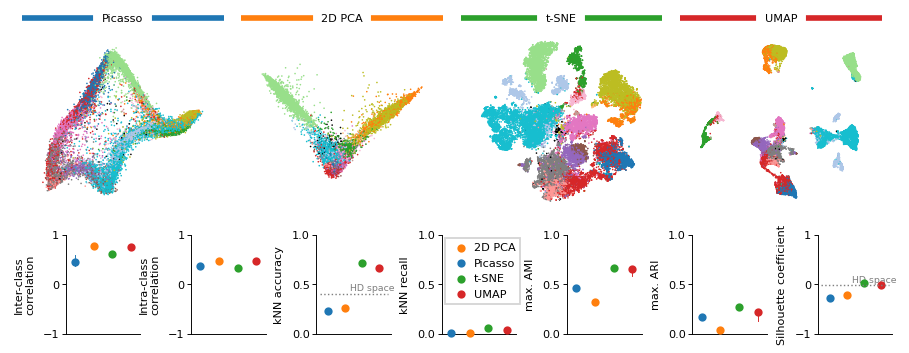

In [23]:
## Own Data
metrics_df_own = adata_own.uns['metrics_df']
ami_df_own = adata_own.uns['ami_df']
ari_df_own = adata_own.uns['ari_df']

ami_max_df_own = get_best_run(ami_df_own,'AMI')
ari_max_df_own = get_best_run(ari_df_own,'ARI')

plot_df_own = pd.concat([metrics_df_own,ami_max_df_own,ari_max_df_own])
plot_df_own = plot_df_own.query('scaled==False')
#exclude L1 distances and balanced accuracy from this plot
filter_metrics_query = 'metric!="intra-cluster L1 distance corr" & metric!="inter-centroid L1 distance corr" & metric!="balanced kNN accuracy"'
plot_df_own = plot_df_own.query(filter_metrics_query)
#pca50_mean_df = plot_df_own.query('embedding_type=="pca50"').groupby(['metric']).mean("metric_value")

#do not plot pca50 as dot
plot_df_own = plot_df_own.query('embedding_type!="pca50"')

with plt.style.context('../mpl_style.txt'):    
    plot_evals_single_dataset(ad=adata_own,plot_df=plot_df_own,pca50_df=None)

/tmp/ipykernel_1274441/2636412976.py:75: UserWarning: There are no gridspecs with layoutgrids. Possibly did not call parent GridSpec with the "figure" keyword
  fig.savefig(f'../results/figures/supplementary/results_{ad.uns["dataset"]}.pdf', dpi=300, format=None, bbox_inches = 'tight', pad_inches = 0)
/tmp/ipykernel_1274441/2636412976.py:76: UserWarning: There are no gridspecs with layoutgrids. Possibly did not call parent GridSpec with the "figure" keyword
  fig.savefig(f'../results/figures/supplementary/results_{ad.uns["dataset"]}.png', dpi=300, format=None, bbox_inches = 'tight', pad_inches = 0)
/data/cephfs-1/home/users/lzaschk_m/work/miniforge3/envs/elephant_analysis_env/lib/python3.11/site-packages/IPython/core/pylabtools.py:170: UserWarning: There are no gridspecs with layoutgrids. Possibly did not call parent GridSpec with the "figure" keyword
  fig.canvas.print_figure(bytes_io, **kw)


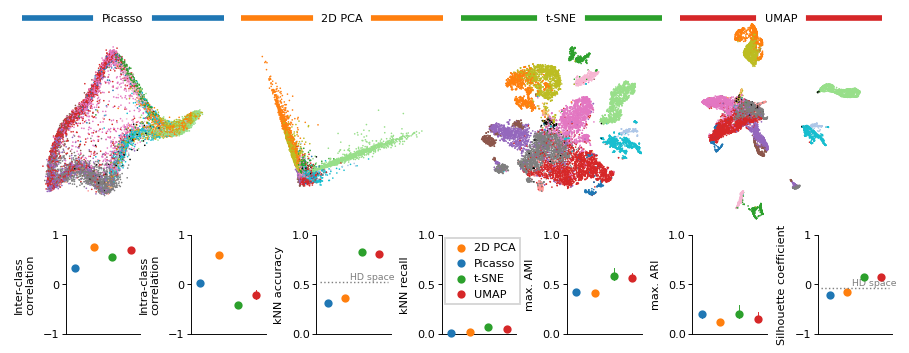

In [24]:
## Own Data
metrics_df_own_a = adata_own_a.uns['metrics_df']
ami_df_own_a = adata_own_a.uns['ami_df']
ari_df_own_a = adata_own_a.uns['ari_df']

ami_max_df_own_a = get_best_run(ami_df_own_a,'AMI')
ari_max_df_own_a = get_best_run(ari_df_own_a,'ARI')

plot_df_own_a = pd.concat([metrics_df_own_a,ami_max_df_own_a,ari_max_df_own_a])
plot_df_own_a = plot_df_own_a.query('scaled==False')
#exclude L1 distances and balanced accuracy from this plot
filter_metrics_query = 'metric!="intra-cluster L1 distance corr" & metric!="inter-centroid L1 distance corr" & metric!="balanced kNN accuracy"'
plot_df_own_a = plot_df_own_a.query(filter_metrics_query)
#pca50_mean_df = plot_df_own.query('embedding_type=="pca50"').groupby(['metric']).mean("metric_value")

#do not plot pca50 as dot
plot_df_own_a = plot_df_own_a.query('embedding_type!="pca50"')

with plt.style.context('../mpl_style.txt'):    
    plot_evals_single_dataset(ad=adata_own_a,plot_df=plot_df_own_a,pca50_df=None)

/tmp/ipykernel_1274441/2636412976.py:75: UserWarning: There are no gridspecs with layoutgrids. Possibly did not call parent GridSpec with the "figure" keyword
  fig.savefig(f'../results/figures/supplementary/results_{ad.uns["dataset"]}.pdf', dpi=300, format=None, bbox_inches = 'tight', pad_inches = 0)
/tmp/ipykernel_1274441/2636412976.py:76: UserWarning: There are no gridspecs with layoutgrids. Possibly did not call parent GridSpec with the "figure" keyword
  fig.savefig(f'../results/figures/supplementary/results_{ad.uns["dataset"]}.png', dpi=300, format=None, bbox_inches = 'tight', pad_inches = 0)
/data/cephfs-1/home/users/lzaschk_m/work/miniforge3/envs/elephant_analysis_env/lib/python3.11/site-packages/IPython/core/pylabtools.py:170: UserWarning: There are no gridspecs with layoutgrids. Possibly did not call parent GridSpec with the "figure" keyword
  fig.canvas.print_figure(bytes_io, **kw)


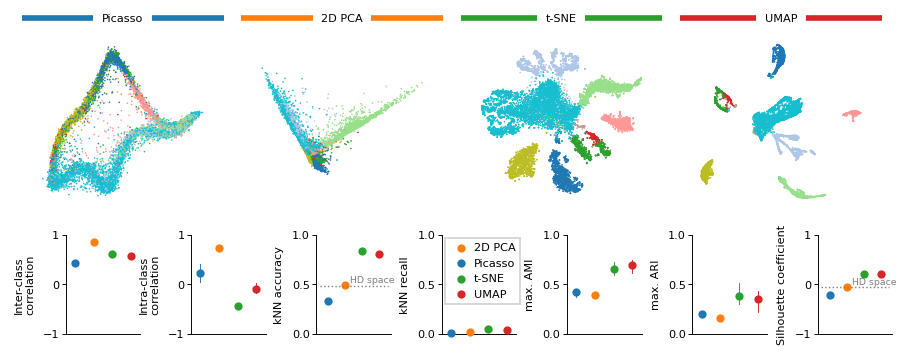

In [25]:
## Own Data
metrics_df_own_b = adata_own_b.uns['metrics_df']
ami_df_own_b = adata_own_b.uns['ami_df']
ari_df_own_b = adata_own_b.uns['ari_df']

ami_max_df_own_b = get_best_run(ami_df_own_b,'AMI')
ari_max_df_own_b = get_best_run(ari_df_own_b,'ARI')

plot_df_own_b = pd.concat([metrics_df_own_b,ami_max_df_own_b,ari_max_df_own_b])
plot_df_own_b = plot_df_own_b.query('scaled==False')
#exclude L1 distances and balanced accuracy from this plot
filter_metrics_query = 'metric!="intra-cluster L1 distance corr" & metric!="inter-centroid L1 distance corr" & metric!="balanced kNN accuracy"'
plot_df_own_b = plot_df_own_b.query(filter_metrics_query)
#pca50_mean_df = plot_df_own.query('embedding_type=="pca50"').groupby(['metric']).mean("metric_value")

#do not plot pca50 as dot
plot_df_own_b = plot_df_own_b.query('embedding_type!="pca50"')

with plt.style.context('../mpl_style.txt'):    
    plot_evals_single_dataset(ad=adata_own_b,plot_df=plot_df_own_b,pca50_df=None)

/tmp/ipykernel_3785111/2636412976.py:75: UserWarning: There are no gridspecs with layoutgrids. Possibly did not call parent GridSpec with the "figure" keyword
  fig.savefig(f'../results/figures/supplementary/results_{ad.uns["dataset"]}.pdf', dpi=300, format=None, bbox_inches = 'tight', pad_inches = 0)
/tmp/ipykernel_3785111/2636412976.py:76: UserWarning: There are no gridspecs with layoutgrids. Possibly did not call parent GridSpec with the "figure" keyword
  fig.savefig(f'../results/figures/supplementary/results_{ad.uns["dataset"]}.png', dpi=300, format=None, bbox_inches = 'tight', pad_inches = 0)
/data/cephfs-1/home/users/lzaschk_m/work/miniforge3/envs/elephant_analysis_env/lib/python3.11/site-packages/IPython/core/pylabtools.py:170: UserWarning: There are no gridspecs with layoutgrids. Possibly did not call parent GridSpec with the "figure" keyword
  fig.canvas.print_figure(bytes_io, **kw)


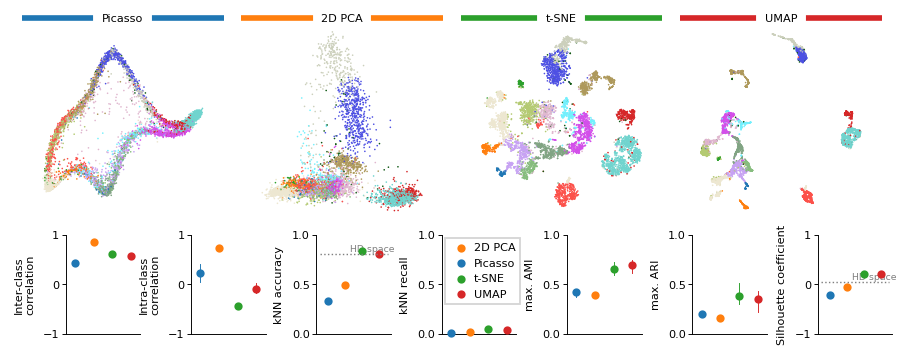

In [152]:
# exut
metrics_df_exut = adata_exut.uns['metrics_df']
ami_df_exut = adata_exut.uns['ami_df']
ari_df_exut = adata_exut.uns['ari_df']

ami_max_df_exut = get_best_run(ami_df_exut,'AMI')
ari_max_df_exut = get_best_run(ari_df_exut,'ARI')

plot_df_exut = pd.concat([metrics_df_exut,ami_max_df_exut,ari_max_df_exut])
plot_df_exut = plot_df_own_b.query('scaled==False')
#exclude L1 distances and balanced accuracy from this plot
filter_metrics_query = 'metric!="intra-cluster L1 distance corr" & metric!="inter-centroid L1 distance corr" & metric!="balanced kNN accuracy"'
plot_df_exut = plot_df_exut.query(filter_metrics_query)
#pca50_mean_df = plot_df_own.query('embedding_type=="pca50"').groupby(['metric']).mean("metric_value")

#do not plot pca50 as dot
plot_df_exut = plot_df_exut.query('embedding_type!="pca50"')

with plt.style.context('../mpl_style.txt'):    
    plot_evals_single_dataset(ad=adata_exut,plot_df=plot_df_exut,pca50_df=None)

/tmp/ipykernel_3785111/2636412976.py:75: UserWarning: There are no gridspecs with layoutgrids. Possibly did not call parent GridSpec with the "figure" keyword
  fig.savefig(f'../results/figures/supplementary/results_{ad.uns["dataset"]}.pdf', dpi=300, format=None, bbox_inches = 'tight', pad_inches = 0)
/tmp/ipykernel_3785111/2636412976.py:76: UserWarning: There are no gridspecs with layoutgrids. Possibly did not call parent GridSpec with the "figure" keyword
  fig.savefig(f'../results/figures/supplementary/results_{ad.uns["dataset"]}.png', dpi=300, format=None, bbox_inches = 'tight', pad_inches = 0)
/data/cephfs-1/home/users/lzaschk_m/work/miniforge3/envs/elephant_analysis_env/lib/python3.11/site-packages/IPython/core/pylabtools.py:170: UserWarning: There are no gridspecs with layoutgrids. Possibly did not call parent GridSpec with the "figure" keyword
  fig.canvas.print_figure(bytes_io, **kw)


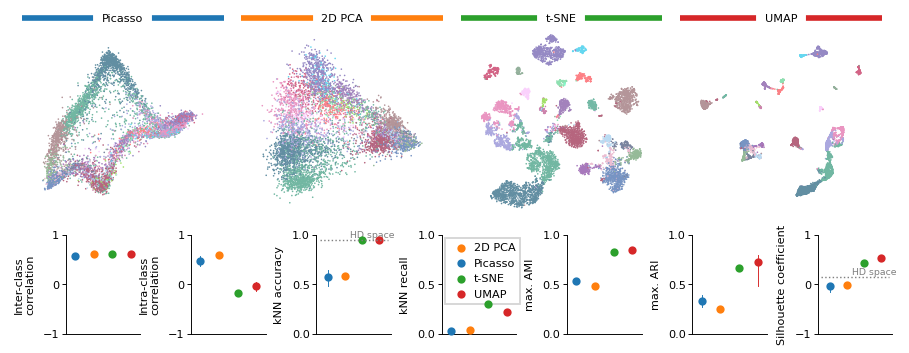

In [154]:
# merfish
metrics_df_merfish= adata_merfish.uns['metrics_df']
ami_df_merfish = adata_merfish.uns['ami_df']
ari_df_merfish = adata_merfish.uns['ari_df']

ami_max_df_merfish = get_best_run(ami_df_merfish,'AMI')
ari_max_df_merfish = get_best_run(ari_df_merfish,'ARI')

plot_df_merfish = pd.concat([metrics_df_merfish,ami_max_df_merfish,ari_max_df_merfish])
plot_df_merfish = plot_df_merfish.query('scaled==False')
#exclude L1 distances and balanced accuracy from this plot
filter_metrics_query = 'metric!="intra-cluster L1 distance corr" & metric!="inter-centroid L1 distance corr" & metric!="balanced kNN accuracy"'
plot_df_merfish = plot_df_merfish.query(filter_metrics_query)
#pca50_mean_df = plot_df_own.query('embedding_type=="pca50"').groupby(['metric']).mean("metric_value")

#do not plot pca50 as dot
plot_df_merfish = plot_df_merfish.query('embedding_type!="pca50"')

with plt.style.context('../mpl_style.txt'):    
    plot_evals_single_dataset(ad=adata_merfish,plot_df=plot_df_merfish,pca50_df=None)

/tmp/ipykernel_3785111/2636412976.py:75: UserWarning: There are no gridspecs with layoutgrids. Possibly did not call parent GridSpec with the "figure" keyword
  fig.savefig(f'../results/figures/supplementary/results_{ad.uns["dataset"]}.pdf', dpi=300, format=None, bbox_inches = 'tight', pad_inches = 0)
/tmp/ipykernel_3785111/2636412976.py:76: UserWarning: There are no gridspecs with layoutgrids. Possibly did not call parent GridSpec with the "figure" keyword
  fig.savefig(f'../results/figures/supplementary/results_{ad.uns["dataset"]}.png', dpi=300, format=None, bbox_inches = 'tight', pad_inches = 0)
/data/cephfs-1/home/users/lzaschk_m/work/miniforge3/envs/elephant_analysis_env/lib/python3.11/site-packages/IPython/core/pylabtools.py:170: UserWarning: There are no gridspecs with layoutgrids. Possibly did not call parent GridSpec with the "figure" keyword
  fig.canvas.print_figure(bytes_io, **kw)


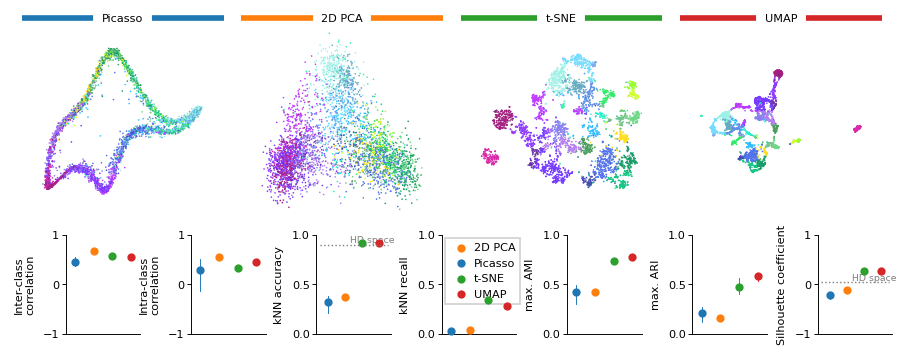

In [155]:
# smartseq
metrics_df_smartseq = adata_smartseq.uns['metrics_df']
ami_df_smartseq = adata_smartseq.uns['ami_df']
ari_df_smartseq = adata_smartseq.uns['ari_df']

ami_max_df_smartseq = get_best_run(ami_df_smartseq,'AMI')
ari_max_df_smartseq = get_best_run(ari_df_smartseq,'ARI')

plot_df_smartseq = pd.concat([metrics_df_smartseq,ami_max_df_smartseq,ari_max_df_smartseq])
plot_df_smartseq = plot_df_smartseq.query('scaled==False')
#exclude L1 distances and balanced accuracy from this plot
filter_metrics_query = 'metric!="intra-cluster L1 distance corr" & metric!="inter-centroid L1 distance corr" & metric!="balanced kNN accuracy"'
plot_df_smartseq = plot_df_smartseq.query(filter_metrics_query)
#pca50_mean_df = plot_df_own.query('embedding_type=="pca50"').groupby(['metric']).mean("metric_value")

#do not plot pca50 as dot
plot_df_smartseq = plot_df_smartseq.query('embedding_type!="pca50"')

with plt.style.context('../mpl_style.txt'):    
    plot_evals_single_dataset(ad=adata_smartseq,plot_df=plot_df_smartseq,pca50_df=None)

In [157]:
#means per dataset x embedding type
only_acc_df = plot_df.query('scaled==False & metric=="kNN accuracy"')
only_rec_df = plot_df.query('scaled==False & metric=="kNN recall"')
only_sil_df = plot_df.query('scaled==False & metric=="silhouette_score"')
only_ami_df = plot_df.query('scaled==False & metric=="max AMI"')
only_ari_df = plot_df.query('scaled==False & metric=="max ARI"')
acc_means = only_acc_df.groupby(by=['dataset','embedding_type'])['metric_value'].aggregate(np.mean)
rec_means = only_rec_df.groupby(by=['dataset','embedding_type'])['metric_value'].aggregate(np.mean)
sil_means = only_sil_df.groupby(by=['dataset','embedding_type'])['metric_value'].aggregate(np.mean)
ami_means = only_ami_df.groupby(by=['dataset','embedding_type'])['metric_value'].aggregate(np.mean)
ari_means = only_ari_df.groupby(by=['dataset','embedding_type'])['metric_value'].aggregate(np.mean)
print('\n\nmean kNN accuracy\n')
print(acc_means.round(decimals=2))
print('\n\nmean kNN recall\n')
print(rec_means.round(decimals=2))
print('\n\nmean silhouette\n')
print(sil_means.round(decimals=2))
print('\n\nmean max AMI\n')
print(ami_means.round(decimals=2))
print('\n\nmean max ARI\n')
print(ari_means.round(decimals=2))



mean kNN accuracy

dataset        embedding_type
O_RTK1_m_2a    elephant          0.31
               pca2              0.36
               tsne              0.83
               umap              0.81
O_RTK1_m_2a+b  elephant          0.23
               pca2              0.26
               tsne              0.72
               umap              0.66
O_RTK1_m_2b    elephant          0.33
               pca2              0.49
               tsne              0.83
               umap              0.80
exut           elephant          0.57
               pca2              0.61
               tsne              0.93
               umap              0.93
merfish        elephant          0.58
               pca2              0.59
               tsne              0.95
               umap              0.95
smartseq       elephant          0.32
               pca2              0.37
               tsne              0.91
               umap              0.91
Name: metric_value, dtype: float64




### Simulated Ex Utero

/tmp/ipykernel_16546/665209090.py:75: UserWarning: There are no gridspecs with layoutgrids. Possibly did not call parent GridSpec with the "figure" keyword
  fig.savefig(f'../results/figures/supplementary/results_{ad.uns["dataset"]}.pdf', dpi=300, format=None, bbox_inches = 'tight', pad_inches = 0)
/tmp/ipykernel_16546/665209090.py:76: UserWarning: There are no gridspecs with layoutgrids. Possibly did not call parent GridSpec with the "figure" keyword
  fig.savefig(f'../results/figures/supplementary/results_{ad.uns["dataset"]}.png', dpi=300, format=None, bbox_inches = 'tight', pad_inches = 0)
/home/jan/anaconda3/envs/elephant_analysis_env/lib/python3.11/site-packages/IPython/core/pylabtools.py:152: UserWarning: There are no gridspecs with layoutgrids. Possibly did not call parent GridSpec with the "figure" keyword
  fig.canvas.print_figure(bytes_io, **kw)


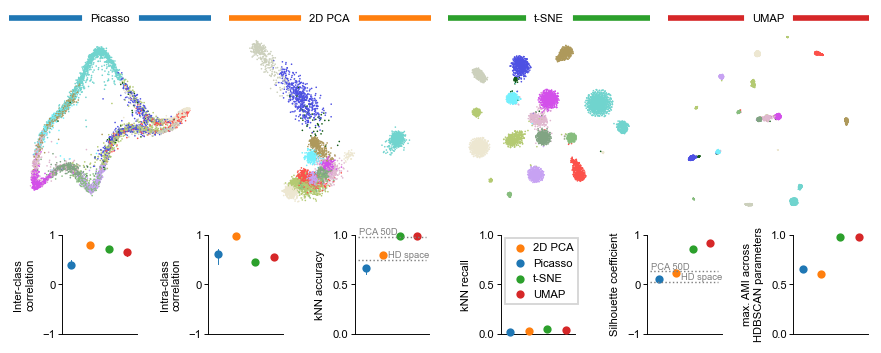

In [28]:
metrics_df_sim = adata_sim.uns['metrics_df']
ami_df_sim = adata_sim.uns['ami_df']

ami_max_df_sim = get_best_run(ami_df_sim,'AMI')
plot_df_sim = pd.concat([metrics_df_sim,ami_max_df_sim])
plot_df_sim = plot_df_sim.query('scaled==False')
#exclude L1 distances and balanced accuracy from this plot
filter_metrics_query = 'metric!="intra-cluster L1 distance corr" & metric!="inter-centroid L1 distance corr" & metric!="balanced kNN accuracy"'
plot_df_sim = plot_df_sim.query(filter_metrics_query)
pca50_mean_df = plot_df_sim.query('embedding_type=="pca50"').groupby(['metric']).mean("metric_value")

#do not plot pca50 as dot
plot_df_sim = plot_df_sim.query('embedding_type!="pca50"')

with plt.style.context('../mpl_style.txt'):    
    plot_evals_single_dataset(ad=adata_sim,plot_df=plot_df_sim,pca50_df=pca50_mean_df)

### MNIST

/tmp/ipykernel_16546/665209090.py:75: UserWarning: There are no gridspecs with layoutgrids. Possibly did not call parent GridSpec with the "figure" keyword
  fig.savefig(f'../results/figures/supplementary/results_{ad.uns["dataset"]}.pdf', dpi=300, format=None, bbox_inches = 'tight', pad_inches = 0)
/tmp/ipykernel_16546/665209090.py:76: UserWarning: There are no gridspecs with layoutgrids. Possibly did not call parent GridSpec with the "figure" keyword
  fig.savefig(f'../results/figures/supplementary/results_{ad.uns["dataset"]}.png', dpi=300, format=None, bbox_inches = 'tight', pad_inches = 0)
/home/jan/anaconda3/envs/elephant_analysis_env/lib/python3.11/site-packages/IPython/core/pylabtools.py:152: UserWarning: There are no gridspecs with layoutgrids. Possibly did not call parent GridSpec with the "figure" keyword
  fig.canvas.print_figure(bytes_io, **kw)


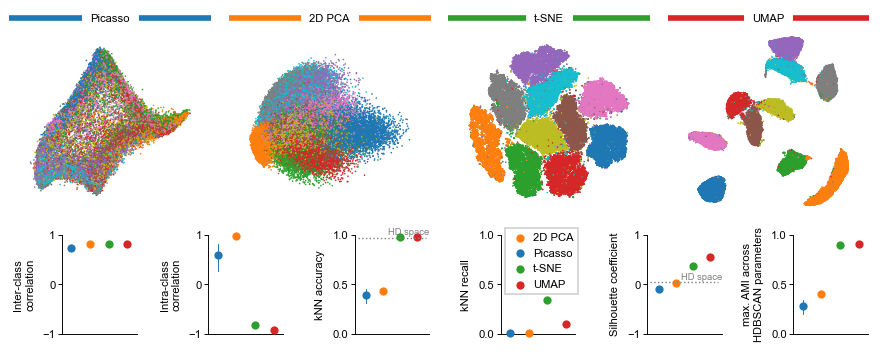

In [29]:
metrics_df_mnist = adata_mnist.uns['metrics_df']
ami_df_mnist = adata_mnist.uns['ami_df']

ami_max_df_mnist = get_best_run(ami_df_mnist,'AMI')
plot_df_mnist = pd.concat([metrics_df_mnist,ami_max_df_mnist])
plot_df_mnist = plot_df_mnist.query('scaled==False')
plot_df_mnist = plot_df_mnist.query(filter_metrics_query)

with plt.style.context('../mpl_style.txt'):    
    plot_evals_single_dataset(ad=adata_mnist,plot_df=plot_df_mnist,legend_loc_metrics=(0.05,0.4))

## Package versions

In [30]:
np.__version__

'1.24.3'

In [31]:
pd.__version__

'2.0.3'

In [32]:
anndata.__version__

'0.10.3'

In [33]:
import matplotlib; matplotlib.__version__

'3.7.2'

In [34]:
sns.__version__

'0.12.2'

In [152]:
palette = {'elephant_x_O_RTK1_m_2a+b':'tab:blue',
           'pca2_x_O_RTK1_m_2a+b':'tab:orange',
           'tsne_x_O_RTK1_m_2a+b':'tab:green',
           'umap_x_O_RTK1_m_2a+b':'tab:red',
           'dummy1':'k', #empty category for column spacing between datasets
           'dummy2':'k', #empty category for column spacing between datasets
           'elephant_x_O_RTK1_m_2a':'tab:blue',
           'pca2_x_O_RTK1_m_2a':'tab:orange',
           'tsne_x_O_RTK1_m_2a':'tab:green',
           'umap_x_O_RTK1_m_2a':'tab:red',
           'dummy3':'k', #empty category for column spacing between datasets
           'dummy4':'k', #empty category for column spacing between datasets
           'elephant_x_O_RTK1_m_2b':'tab:blue',
           'pca2_x_O_RTK1_m_2b':'tab:orange',
           'tsne_x_O_RTK1_m_2b':'tab:green',
           'umap_x_O_RTK1_m_2b':'tab:red'}

In [249]:
## OLD ## 
palette = {'elephant_x_exut':'tab:blue',
           'pca2_x_exut':'tab:orange',
           'tsne_x_exut':'tab:green',
           'umap_x_exut':'tab:red',
           'dummy1':'k', #empty category for column spacing between datasets
           'dummy2':'k', #empty category for column spacing between datasets
           'elephant_x_merfish':'tab:blue',
           'pca2_x_merfish':'tab:orange',
           'tsne_x_merfish':'tab:green',
           'umap_x_merfish':'tab:red',
           'dummy3':'k', #empty category for column spacing between datasets
           'dummy4':'k', #empty category for column spacing between datasets
           'elephant_x_smartseq':'tab:blue',
           'pca2_x_smartseq':'tab:orange',
           'tsne_x_smartseq':'tab:green',
           'umap_x_smartseq':'tab:red',
           'dummy5':'k', #empty category for column spacing between datasets
           'dummy6':'k', #empty category for column spacing between datasets
           'elephant_x_O_RTK1_m_2a+b':'tab:blue',
           'pca2_x_O_RTK1_m_2a+b':'tab:orange',
           'tsne_x_O_RTK1_m_2a+b':'tab:green',
           'umap_x_O_RTK1_m_2a+b':'tab:red',
           'dummy7':'k', #empty category for column spacing between datasets
           'dummy8':'k', #empty category for column spacing between datasets
           'elephant_x_O_RTK1_m_2a':'tab:blue',
           'pca2_x_O_RTK1_m_2a':'tab:orange',
           'tsne_x_O_RTK1_m_2a':'tab:green',
           'umap_x_O_RTK1_m_2a':'tab:red',
           'dummy9':'k', #empty category for column spacing between datasets
           'dummy10':'k', #empty category for column spacing between datasets
           'elephant_x_O_RTK1_m_2b':'tab:blue',
           'pca2_x_O_RTK1_m_2b':'tab:orange',
           'tsne_x_O_RTK1_m_2b':'tab:green',
           'umap_x_O_RTK1_m_2b':'tab:red'}

In [253]:
col_order = [f'inter-centroid distance corr',
             f'intra-cluster distance corr',
             'kNN accuracy',
             'kNN recall',
             'max AMI',
             'max ARI',
             'silhouette_score'
             ]

pretty_metrics_dict = {f'inter-centroid distance corr':'Inter-class\ncorrelation',
                           f'intra-cluster distance corr':'Intra-class\ncorrelation',
                           'kNN accuracy':'kNN accuracy',
                           'kNN recall':"kNN recall",
                           'max AMI':'max. AMI',
                           'max ARI':'max. ARI',
                           'silhouette_score':'Silhouette coefficient'}

def plot_evals(plot_df, knn_accuracies_hd_dict, silhouette_scores_hd_dict,
               file_suffix, suptitle, folder='main',
               height=3, aspect=1.5, legend_loc=(0.4, 0.3), scale=1):

    g = sns.FacetGrid(plot_df, col="metric", col_wrap=2, sharey=False, sharex=False,
                      height=height, aspect=aspect, col_order=col_order)

    g.map_dataframe(sns.pointplot,
                    errorbar=("pi", 100),
                    x='embedding_x_dataset',
                    hue='embedding_x_dataset',
                    markers=['o']*4 + ['^']*4 + ['s']*4 + ['D']*4 + ['X']*4 + ['P']*4,
                    errwidth=0.5,
                    y="metric_value",
                    palette=palette,
                    order=list(palette.keys()),
                    dodge=False,
                    scale=scale)

    legend_data = g._legend_data
    new_legend_data = {'2D PCA': legend_data['pca2_x_O_RTK1_m_2a+b'],
                       'Picasso': legend_data['elephant_x_O_RTK1_m_2a+b'],
                       't-SNE': legend_data['tsne_x_O_RTK1_m_2a+b'],
                       'UMAP': legend_data['umap_x_O_RTK1_m_2a+b']}
    g.add_legend(legend_data=new_legend_data, loc=legend_loc, frameon=True, ncols=2, columnspacing=0.1, handletextpad=0.1)

    for metric, ax in g.axes_dict.items():
        plt.sca(ax)

        tick_positions = [1.5, 7.5, 13.5, 19.5, 25.5, 31.5]  # Adjusted positions
        plt.xticks(tick_positions, ['exut', 'merfish', 'smartseq', 'a+b', 'a', 'b'])

        plt.tick_params(bottom=False)
        plt.xlabel('')
        plt.ylabel(pretty_metrics_dict[metric])
        plt.title('')

        mindata_intra = np.min(plot_df.query(f'metric=="intra-cluster distance corr"')['metric_value'])
        ylim_lo = -0.05
        ax.set_yticks([0, 0.5, 1])

        if metric == "inter-centroid distance corr":
            ylim_lo += mindata_intra
            letter = 'a'

        if metric == "intra-cluster distance corr":
            ylim_lo += mindata_intra
            letter = 'b'

        if metric == "kNN accuracy":
            # Adjust horizontal lines based on new tick_positions
            ax.hlines(knn_accuracies_hd_dict['exut'], tick_positions[0] - 2, tick_positions[0] + 2, colors='tab:gray', linestyles=':')
            ax.hlines(knn_accuracies_hd_dict['merfish'], tick_positions[1] - 2, tick_positions[1] + 2, colors='tab:gray', linestyles=':')
            ax.hlines(knn_accuracies_hd_dict['smartseq'], tick_positions[2] - 2, tick_positions[2] + 2, colors='tab:gray', linestyles=':')
            ax.hlines(knn_accuracies_hd_dict['O_RTK1_m_2a+b'], tick_positions[3] - 2, tick_positions[3] + 2, colors='tab:gray', linestyles=':')
            ax.hlines(knn_accuracies_hd_dict['O_RTK1_m_2a'], tick_positions[4] - 2, tick_positions[4] + 2, colors='tab:gray', linestyles=':')
            ax.hlines(knn_accuracies_hd_dict['O_RTK1_m_2b'], tick_positions[5] - 2, tick_positions[5] + 2, colors='tab:gray', linestyles=':')
            ax.text(x=-0.1, y=knn_accuracies_hd_dict['O_RTK1_m_2a+b'] + 0.03, s='\nHD space', c='tab:gray', fontsize=5)
            letter = 'c'

        if metric == 'kNN recall':
            letter = 'd'

        if metric == 'max AMI':
            letter = 'e'

        if metric == 'max ARI':
            letter = 'f'

        if metric == 'silhouette_score':
            letter = 'g'
            ylim_lo += -0.5
            ax.set_yticks([-0.5, 0, 0.5, 1])

            # Adjust horizontal lines based on new tick_positions
            ax.hlines(silhouette_scores_hd_dict['exut'], tick_positions[0] - 2, tick_positions[0] + 2, colors='tab:gray', linestyles=':')
            ax.hlines(silhouette_scores_hd_dict['merfish'], tick_positions[1] - 2, tick_positions[1] + 2, colors='tab:gray', linestyles=':')
            ax.hlines(silhouette_scores_hd_dict['smartseq'], tick_positions[2] - 2, tick_positions[2] + 2, colors='tab:gray', linestyles=':')
            ax.hlines(silhouette_scores_hd_dict['O_RTK1_m_2a+b'], tick_positions[3] - 2, tick_positions[3] + 2, colors='tab:gray', linestyles=':')
            ax.hlines(silhouette_scores_hd_dict['O_RTK1_m_2a'], tick_positions[4] - 2, tick_positions[4] + 2, colors='tab:gray', linestyles=':')
            ax.hlines(silhouette_scores_hd_dict['O_RTK1_m_2b'], tick_positions[5] - 2, tick_positions[5] + 2, colors='tab:gray', linestyles=':')
            ax.text(x=-0.1, y=silhouette_scores_hd_dict['O_RTK1_m_2a+b'] + 0.05, s='HD space', c='tab:gray', fontsize=5)

        ax.set_ylim(ylim_lo, top=1)
        for tick_pos in tick_positions:
            ax.hlines(ylim_lo, tick_pos - 2, tick_pos + 2, colors='k', lw=0.5)

        #if letter in ['c', 'd']:
            y_correction = 0.0025
        #else:
        #    y_correction = 0
        #if letter in ['f']:
        #    x_correction = 0.02
        #else:
        #    x_correction = 0

        #ax.text(-0.17 + x_correction, 0.9675 + y_correction, letter, transform=ax.transAxes, fontweight='bold', fontsize=8)
        plt.setp(ax.lines, zorder=100, clip_on=False)
        plt.setp(ax.collections, zorder=100, label="", clip_on=False)

    plt.tight_layout()
    sns.despine(trim=True, bottom=True)

    plt.suptitle(suptitle, y=1.03)
    g.figure.savefig(f'../results/figures/{folder}/metrics{file_suffix}_full.pdf', dpi=300, format=None, bbox_inches='tight', pad_inches=0)
    g.figure.savefig(f'../results/figures/{folder}/metrics{file_suffix}_full.png', dpi=300, format=None, bbox_inches='tight', pad_inches=0)

    plt.show()
    return g

In [161]:
#select only L2-based metrics for remaining figures
l2_query = 'metric!="intra-cluster L1 distance corr" & metric!="inter-centroid L1 distance corr"'
plot_df_normal_l2 = plot_df_normal.query(l2_query)
plot_df_scaled_l2 = plot_df_scaled.query(l2_query)

### Main figure
(unscaled high-dimensional space used for embeddings and evaluation)

/data/cephfs-1/home/users/lzaschk_m/work/miniforge3/envs/elephant_analysis_env/lib/python3.11/site-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)
/data/cephfs-1/home/users/lzaschk_m/work/miniforge3/envs/elephant_analysis_env/lib/python3.11/site-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)
/tmp/ipykernel_3785111/2514754229.py:118: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


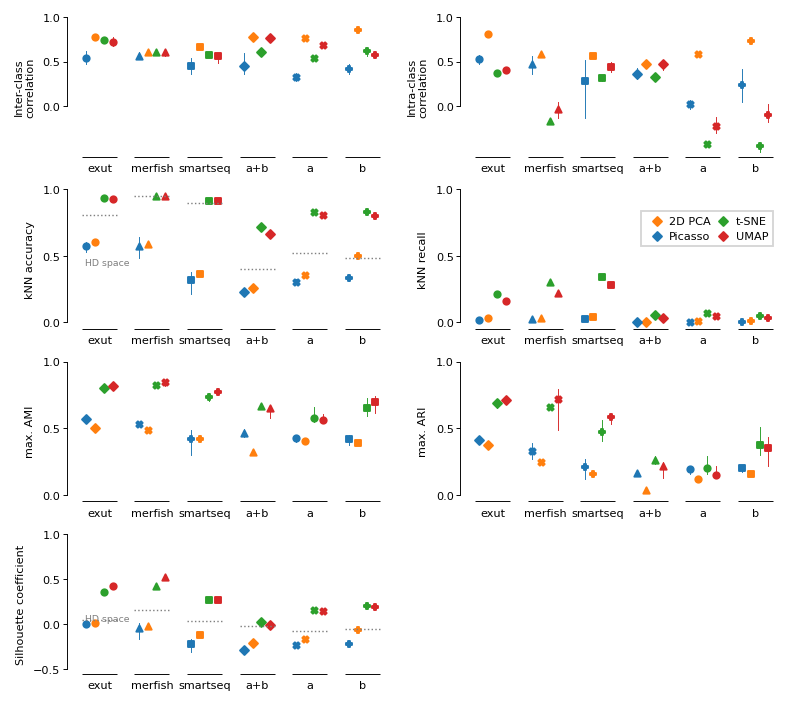

In [254]:
with plt.style.context('../mpl_style.txt'):
    g=plot_evals(plot_df_normal_l2,file_suffix="_unscaled_L2",suptitle="",
                 knn_accuracies_hd_dict=knn_accuracies_hd,silhouette_scores_hd_dict=silhouette_scores_hd,
                 height=1.3,aspect=1.9,legend_loc=(0.8,0.65),scale=1)